In [1]:
import sympy as sp
from sympy.core.numbers import pi
from IPython.display import display
from latex2sympy2 import latex2sympy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

Here I am going to try and recreate the results from: https://www.sciencedirect.com/science/article/pii/S0304399123001250?via%3Dihub
for deflection of an electron ray through a wire. Specifically the results from Figure 13 & 14.

In [2]:
tol = 1e-12
sp.init_printing()

x, y, z, K, eps_0 = sp.symbols('x y z K epsilon_0')
a, b = sp.symbols('a b')

def make_double_wire_potential_and_efield(phi, phi_0, x, y, z, K, eps_0, eps, a,
                                          x_displacement, y_displacement, K_val,
                                          eps_0_val, length):
    
    #Substitute correct constants into the wire potential
    phi = phi.subs({K: K_val, eps_0: eps_0_val, pi: np.pi, a: length})
    
    #Create the top and bottom wire
    phi_top_wire = phi
    phi_bottom_wire = phi.subs({x:-(x-x_displacement), y:-(y-y_displacement)})

    #Make the first wire positively charged, and the second negatively charged
    phi_wires = phi_top_wire - phi_bottom_wire
    
    #Create the phi_hat version of this function for refractive index calculation
    phi_hat_wires = (phi_wires)*(1+eps*(phi_wires))
    
    #Include the initial potential of the electron from the gun. 
    phi_wires_electron = phi_0 - phi_wires
    
    #Create phi_hat function from hawkes (2.18)
    phi_hat_wires_electron = (phi_wires_electron)*(1+eps*(phi_wires_electron))
    
    #Get E field function. Notive there is no negative sign, as the way hawkes uses phi_hat, there is no minus before it (Equation 3.22).
    dphi_hat_wires_electron_dx = phi_hat_wires_electron.diff(x)
    dphi_hat_wires_electron_dy = phi_hat_wires_electron.diff(y)
    dphi_hat_wires_electron_dz = phi_hat_wires_electron.diff(z)

    phi_wires_lambda = sp.lambdify([x, y, z], phi_wires, 'numpy')
    phi_hat_wires_lambda = sp.lambdify([x, y, z], phi_hat_wires, 'numpy')
    phi_hat_wires_electron_lambda = sp.lambdify([x, y, z], phi_hat_wires_electron, 'numpy')
    dphi_hat_wires_electron_lambda = sp.lambdify([x, y, z], [dphi_hat_wires_electron_dx, dphi_hat_wires_electron_dy, dphi_hat_wires_electron_dz], 'numpy')
    
    return phi_hat_wires_electron_lambda, dphi_hat_wires_electron_lambda, phi_wires_lambda, phi_hat_wires_lambda

In [3]:
e = -1.60217662e-19 #unit C
m = 9.10938356e-31 #unit kg
c = 2.99792458e8 #unit m/s
eps_0_val = 8.85418782e-12 #permittivity unit F/m

phi_0 = 1e5 #unit V
eta = (abs(e)/(2*m))**(1/2) #Constant from Hawkes
eps = abs(e)/(2*m*c**2) #eps as defined in Hawkes, different from the permittivity of free space. 

phi = (K/(4*pi*eps_0))*(sp.log((sp.sqrt(x**2+(y+a)**2 + z**2)+y+a)/(sp.sqrt(x**2+y**2+z**2)+y)))


K_val = 3 #unit e/nm - convert to coulombs per m? 
K_val_SI = (K_val*abs(e))/1e-9 #C/m
y_displacement = 200e-9 #unit m
x_displacement = 0. #unit m
a_val = 0.618e-3 #unit m

phi_hat_lambda, dphi_hat_lambda, phi_wires_lambda, phi_hat_wires_lambda= make_double_wire_potential_and_efield(phi, phi_0, x, y, z, K, eps_0, eps, a, x_displacement, y_displacement, 
                                                                        K_val_SI, eps_0_val, a_val)

Text(0, 0.5, 'y (m)')

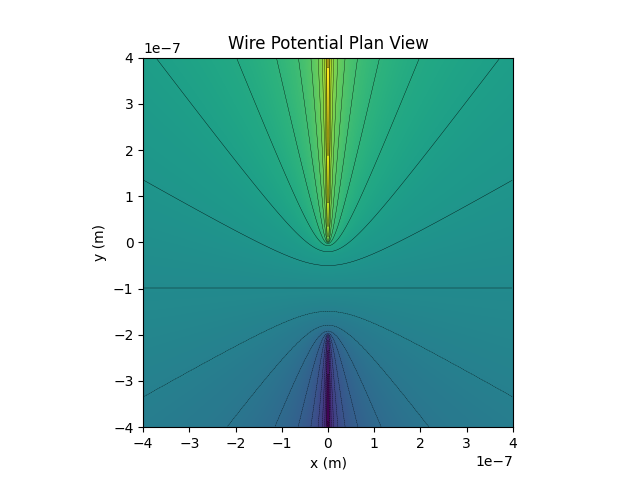

In [4]:
x_line = np.linspace(-1, 1, 1000)
y_line = np.linspace(-1, 1, 1000)
x_grid, y_grid = np.meshgrid(x_line, y_line)

plan_figure, plan_ax = plt.subplots()
x_line, xstep = np.linspace(-400e-9, 400e-9, 300, retstep = True)
y_line, ystep = np.linspace(-400e-9, 400e-9, 300, retstep = True)
x_grid, y_grid = np.meshgrid(x_line, y_line)
z_grid = 0*np.ones(x_grid.shape)

potential_image = phi_wires_lambda(x_grid, y_grid, 0)
plan_ax.imshow(potential_image, extent=[-400e-9, 400e-9, -400e-9, 400e-9])
plan_ax.contour(potential_image, 25, linewidths = 0.25, colors = 'k', extent = [-400e-9, 400e-9, -400e-9, 400e-9], origin = 'upper')
plan_ax.set_title('Wire Potential Plan View')
plan_ax.set_xlabel('x (m)')
plan_ax.set_ylabel('y (m)')

<lambdifygenerated-1>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 4.57908721840319*log((y + sqrt(x**2 + z**2 + (y + 0.000618)**2) + 0.000618)/(y + sqrt(x**2 + y**2 + z**2))) - 4.57908721840319*log((-y + sqrt(x**2 + z**2 + (0.0006182 - y)**2) + 0.0006182)/(-y + sqrt(x**2 + z**2 + (2.0e-7 - y)**2) + 2.0e-7))
<lambdifygenerated-1>:2: RuntimeWarning: divide by zero encountered in divide
  return 4.57908721840319*log((y + sqrt(x**2 + z**2 + (y + 0.000618)**2) + 0.000618)/(y + sqrt(x**2 + y**2 + z**2))) - 4.57908721840319*log((-y + sqrt(x**2 + z**2 + (0.0006182 - y)**2) + 0.0006182)/(-y + sqrt(x**2 + z**2 + (2.0e-7 - y)**2) + 2.0e-7))


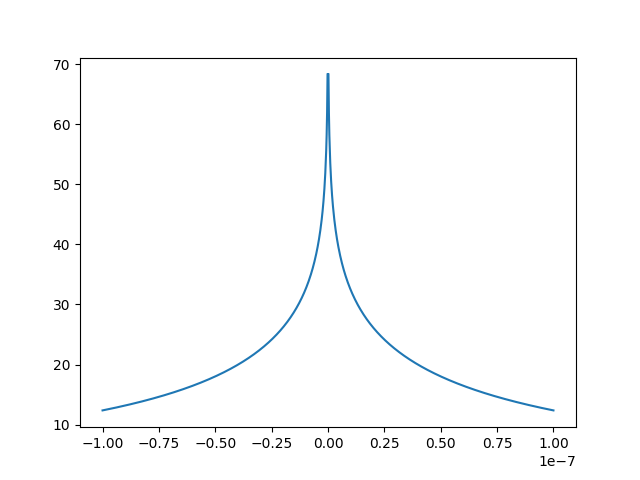

In [5]:
phi_wires_lambda(0, -100e-9, 0)
z = np.linspace(-100e-9, 100e-9, 1001)

plt.figure()
plt.plot(z, phi_wires_lambda(0, -100e-9, z))

In [6]:
def odedopri(f,  x0,  y0,  x1,  tol,  hmax,  hmin,  maxiter, args=()):
    a21 = (1.0/5.0)
    a31 = (3.0/40.0)
    a32 = (9.0/40.0)
    a41 = (44.0/45.0)
    a42 = (-56.0/15.0)
    a43 = (32.0/9.0)
    a51 = (19372.0/6561.0)
    a52 = (-25360.0/2187.0)
    a53 = (64448.0/6561.0)
    a54 = (-212.0/729.0)
    a61 = (9017.0/3168.0)
    a62 = (-355.0/33.0)
    a63 = (46732.0/5247.0)
    a64 = (49.0/176.0)
    a65 = (-5103.0/18656.0)
    a71 = (35.0/384.0)
    a72 = (0.0)
    a73 = (500.0/1113.0)
    a74 = (125.0/192.0)
    a75 = (-2187.0/6784.0)
    a76 = (11.0/84.0)
    c2 = (1.0 / 5.0)
    c3 = (3.0 / 10.0)
    c4 = (4.0 / 5.0)
    c5 = (8.0 / 9.0)
    c6 = (1.0)
    c7 = (1.0)
    b1 = (35.0/384.0)
    b2 = (0.0)
    b3 = (500.0/1113.0)
    b4 = (125.0/192.0)
    b5 = (-2187.0/6784.0)
    b6 = (11.0/84.0)
    b7 = (0.0)
    b1p = (5179.0/57600.0)
    b2p = (0.0)
    b3p = (7571.0/16695.0)
    b4p = (393.0/640.0)
    b5p = (-92097.0/339200.0)
    b6p = (187.0/2100.0)
    b7p = (1.0/40.0)
    x = x0
    y = y0
    h = hmax
    X = np.zeros(maxiter)
    X[0] = x0
    Y = np.zeros((maxiter, len(y0)))
    Y[0] = y0
    
    #We need a special step counter because the ODE dormand prince 
    #method will do a step again with a smaller step size if the error is too large
    step = 1
    for i in range(maxiter):
       # /* Compute the function values */
       K1 = f(x,       y, *args)
       K2 = f(x + c2*h, y+h*(a21*K1), *args)
       K3 = f(x + c3*h, y+h*(a31*K1+a32*K2), *args)
       K4 = f(x + c4*h, y+h*(a41*K1+a42*K2+a43*K3), *args)
       K5 = f(x + c5*h, y+h*(a51*K1+a52*K2+a53*K3+a54*K4), *args)
       K6 = f(x + h, y+h*(a61*K1+a62*K2+a63*K3+a64*K4+a65*K5), *args)
       K7 = f(x + h, y+h*(a71*K1+a72*K2+a73*K3+a74*K4+a75*K5+a76*K6), *args)
       error = abs((b1-b1p)*K1+(b3-b3p)*K3+(b4-b4p)*K4+(b5-b5p)*K5 +
                   (b6-b6p)*K6+(b7-b7p)*K7)
       #Error in X controls tolerance
       error = max(error)
       # error control
       if error != 0.0:
           delta = 0.84 * pow(tol / error, (1.0/5.0))
       else:
           delta = np.inf
       if (error < tol):
          x = x + h
          X[step] = x
          y = y + h * (b1*K1+b3*K3+b4*K4+b5*K5+b6*K6)
          Y[step, :] = y
          step+=1
       if (delta <= 0.1):
          h = h * 0.1
       elif (delta >= 4.0):
          h = h * 4.0
       else:
          h = delta * h
       if (h > hmax):
          h = hmax
       if (x >= x1):
          print('reached end')
          break
       elif (x + h > x1):
          h = x1 - x
       elif (h < hmin):
          print('Below hmin')
          print(step)
          print(x)
          break
    return X, Y, step

def trajectory_equation_of_motion(z, x, phi_hat_lambda, dphi_hat_lambda):
    
    p = np.sqrt(1+x[1]**2+x[3]**2) #obtain slope of ray
    phi_hat = phi_hat_lambda(x[0], x[2], z) #evaluate potential
    dphi_hat_x, dphi_hat_y, dphi_hat_z = dphi_hat_lambda(x[0], x[2], z) #evaluate the efield
    
    return np.array([x[1], (p**2)/(2*phi_hat)*(dphi_hat_x-x[1]*dphi_hat_z), x[3], (p**2)/(2*phi_hat)*(dphi_hat_y-x[3]*dphi_hat_z)]) #evaluate the velocities and accelerations, [vx, ax, vy, ay]

In [7]:
x0 = np.array([0, 0, -y_displacement/2, 0]) #x, x', y, y'
z0 = -50e-6 #Initial z plane
zF = 50e-6 #Final z plane

tol = 1e-1#error tolerance in the calculation (error in force or velocity on one axis is no larger than tolerance)
max_step_size = 1e-5 #m
min_step_size = 1e-14 #m
z_out, x_out, steps = odedopri(trajectory_equation_of_motion,  z0,  x0,  zF,  tol ,  max_step_size,  min_step_size,  1000000, args=(phi_hat_lambda, dphi_hat_lambda))

<lambdifygenerated-3>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return (-4.57908721840319*log((y + sqrt(x**2 + z**2 + (y + 0.000618)**2) + 0.000618)/(y + sqrt(x**2 + y**2 + z**2))) + 4.57908721840319*log((-y + sqrt(x**2 + z**2 + (0.0006182 - y)**2) + 0.0006182)/(-y + sqrt(x**2 + z**2 + (2.0e-7 - y)**2) + 2.0e-7)) + 100000.0)*(-4.48052510631766e-6*log((y + sqrt(x**2 + z**2 + (y + 0.000618)**2) + 0.000618)/(y + sqrt(x**2 + y**2 + z**2))) + 4.48052510631766e-6*log((-y + sqrt(x**2 + z**2 + (0.0006182 - y)**2) + 0.0006182)/(-y + sqrt(x**2 + z**2 + (2.0e-7 - y)**2) + 2.0e-7)) + 1.0978475598436)
<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in scalar divide
  return [(-4.57908721840319*(y + sqrt(x**2 + y**2 + z**2))*(x/((y + sqrt(x**2 + y**2 + z**2))*sqrt(x**2 + z**2 + (y + 0.000618)**2)) - x*(y + sqrt(x**2 + z**2 + (y + 0.000618)**2) + 0.000618)/((y + sqrt(x**2 + y**2 + z**2))**2*sqrt(x**2 + y**2 + z**2)))/(y + sqrt(x**2 + z**2 + (y + 0.000618)**2)

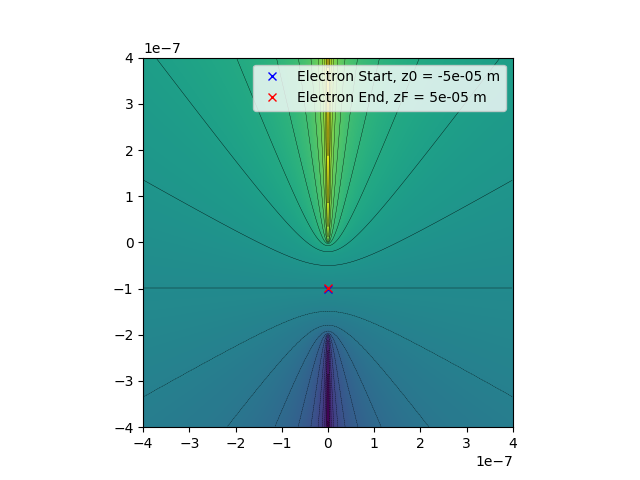

In [8]:
plan_figure, plan_ax = plt.subplots()
x_line, xstep = np.linspace(-400e-9, 400e-9, 300, retstep = True)
y_line, ystep = np.linspace(-400e-9, 400e-9, 300, retstep = True)
x_grid, y_grid = np.meshgrid(x_line, y_line)
z_grid = 0*np.ones(x_grid.shape)

potential_image = phi_wires_lambda(x_grid, y_grid, 0)
plan_ax.imshow(potential_image, extent=[-400e-9, 400e-9, -400e-9, 400e-9])
plan_ax.contour(potential_image, 25, linewidths = 0.25, colors = 'k', extent = [-400e-9, 400e-9, -400e-9, 400e-9], origin = 'upper')
plan_ax.plot(x_out[0, 0], x_out[0, 2], 'xb', label = f'Electron Start, z0 = {z0} m')
plan_ax.plot(x_out[steps-1, 0], x_out[steps-1, 2], 'xr', label = f'Electron End, zF = {zF} m')
plan_ax.legend()

X positional deflection (m): 0.0
Y positional deflection (m): 1.1277399740471405e-09
Latitudinal deflection (nm): 1.1277399740471405


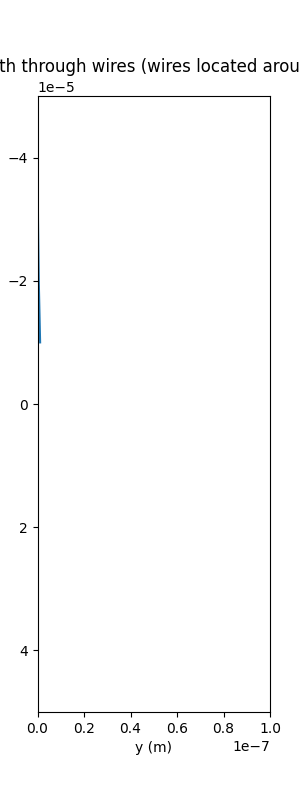

In [9]:
plt.figure(figsize = (3, 8))
plt.xlim([0, 100e-9])
plt.ylim([50e-6, -50e-6])
plt.plot(abs(x_out[0, 2]-x_out[:steps, 2]), z_out[:steps])
plt.title('Ray path through wires (wires located around z=0)')
plt.xlabel('y (m)')
plt.ylabel('z (m)')

print('X positional deflection (m):', abs(x_out[0, 0]-x_out[steps-1, 0]))
print('Y positional deflection (m):', abs(x_out[0, 2]-x_out[steps-1, 2]))

print('Latitudinal deflection (nm):', np.sqrt(abs(x_out[0, 0]-x_out[steps-1, 0])**2+abs(x_out[0, 2]-x_out[steps-1, 2])**2)/1e-9)

In [10]:
x_out[:steps, 2]-(-y_displacement/2)

array([0.00000000e+00, 4.95520379e-11, 2.17062955e-10, 5.45973811e-10,
       1.12773997e-09])